In [1]:
import os, pickle, time, itertools, re, random, subprocess, joblib, pprint, codecs, datetime, shutil, ctypes
from io import StringIO
from os.path import exists
from collections import OrderedDict
from tabulate import tabulate
from itertools import chain, combinations

import numpy as np
from numpy.random import seed

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from matplotlib import pyplot as plt
%matplotlib inline 

# data pipelines/scaling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error

# Algorithms
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
import xgboost as xgb

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Deep Learning stuffz
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt

# optimization
import optuna
import transforms # our script-preserving transform code


# ignore some specific annoying warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

optuna.logging.set_verbosity(optuna.logging.WARNING)

# fix up some numpy disply options
np.set_printoptions(suppress=True)

In [2]:
# fixate the random state for reproducability
RANDOM_STATE = 1337
seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Load Target Models

In [3]:
# the tuned Logisitic Regression model
lr_target_model = pickle.load(open('../models/tuned_ridge.bin', 'rb'))


# the tuned LightGBMClassifier
lgbm_target_model = pickle.load(open('../models/tuned_lgbm.bin', 'rb'))


# the target Neural Network
layers  = 4
neurons = 192
dropout = 0.5

nn_target_model = Sequential()
nn_target_model.add(Dense(neurons, input_dim=446, activation='relu'))
nn_target_model.add(Dropout(dropout))
    
for i in range(layers-1):
    nn_target_model.add(Dense(neurons, activation='relu'))
    nn_target_model.add(Dropout(dropout))

nn_target_model.add(Dense(1, activation='sigmoid'))
nn_target_model.load_weights(f"../models/neural_network/tuned_{layers}_{neurons}_{dropout}.ckpt")

nn_scaler = pickle.load(open('../models/nn_scaler.bin', 'rb'))

C:\Users\wschroeder\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\wschroeder\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\wschroeder\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\wschroeder\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 

# Data Preparation

In [4]:
# read in the labeled black box data set
df = pd.read_csv('../datasets/BlackBoxData.ast.csv')

y = df.Label
X = df.drop( ['Path', 'Label'], axis=1)

# the features we're using that were selected by Boruta-Shap
boruta_shap_accepted_features = ['AstCmdletMetrics_CharacterDistribution_&_26_Percent', 'AstMemberArgumentMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_m_6d_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_{_7b_Count', 'AstGroupedBinaryExpressionOperators_Plus_Count', 'AstGroupedAstTypes_StatementBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_UpperAlphaPercent_Average', 'LineByLineMetrics_CharacterDistribution_(_28_Percent', 'LineByLineMetrics_CharacterDistribution_A_41_Percent', 'AstGroupedBinaryExpressionOperators_Format_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_Length_Median', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstCmdletMetrics_UpperAlphaPercent_Mode', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Count', 'AstVariableNameMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_R_52_Count', 'AstCmdletMetrics_CharacterDistribution_n_6e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Count', 'AstTypeExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Percent', 'AstCmdletMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_CharacterDistribution_n_6e_Percent', 'AstGroupedAstTypes_TypeConstraintAst_Count', 'AstStringMetrics_Entropy_Average', 'AstCmdletMetrics_CharacterDistribution_u_75_Percent', 'AstVariableNameMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_d_64_Percent', 'AstStringMetrics_Length_Average', 'AstVariableNameMetrics_CharacterDistribution_1_31_Percent', 'AstCmdletMetrics_CharacterDistribution_j_6a_Count', 'AstCmdletMetrics_CharacterDistribution_u_75_Count', 'AstGroupedBinaryExpressionOperators_Format_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Average', 'LineByLineMetrics_Length_Mode', 'AstMemberMetrics_Entropy_Maximum', 'LineByLineMetrics_CharacterDistribution_#_23_Percent', 'LineByLineMetrics_CharacterDistribution_e_65_Percent', 'AstCmdletMetrics_CharacterDistribution_-_2d_Count', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_E_45_Percent', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Average', 'AstMemberArgumentMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Percent', 'AstGroupedAstTypes_AttributeAst_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Count', 'LineByLineMetrics_CharacterDistribution_Y_59_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Count', 'AstMemberMetrics_CharacterDistribution_{_7b_Count', 'AstCmdletMetrics_CharacterDistribution_`_60_Count', 'AstVariableNameMetrics_CharacterDistribution_`_60_Percent', 'LineByLineMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberMetrics_CharacterDistribution_(_28_Percent', 'AstStringMetrics_Length_Median', 'AstCmdletMetrics_CharacterDistribution_o_6f_Count', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Count', 'AstMemberMetrics_Entropy_Median', 'AstMemberArgumentMetrics_UpperAlphaPercent_Mode', 'AstInvocationOperatorInvokedObjectMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Minimum', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstMemberMetrics_CharacterDistribution_}_7d_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_x_78_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Mode', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Count", 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Count', 'AstStringMetrics_CharacterDistribution_Q_51_Count', "LineByLineMetrics_CharacterDistribution_'_27_Percent", 'AstArrayElementMetrics_UpperAlphaPercent_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_Length_Total', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Maximum', 'AstTypeExpressionMetrics_CharacterDistribution_B_42_Percent', 'AstGroupedAstTypes_IfStatementAst_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Count', 'AstCmdletMetrics_CharacterDistribution_._2e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Mode', 'AstConvertExpressionMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_i_69_Percent', 'AstVariableNameMetrics_Entropy_Range', "AstArrayElementMetrics_CharacterDistribution_'_27_Count", 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Count', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Count', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstCommentMetrics_Entropy_Average', 'AstStringMetrics_CharacterDistribution_Q_51_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Count', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_Entropy_Maximum', 'AstVariableNameMetrics_CharacterDistribution_m_6d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Count', 'AstVariableNameMetrics_Entropy_Average', 'AstGroupedAstTypes_StringConstantExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution__22_Count"', 'AstCmdletMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberArgumentMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Entropy_Average', 'AstCmdletMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_Length_Total', 'AstTypeConstraintMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Mode', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Count', 'LineByLineMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Count', 'LineByLineMetrics_CharacterDistribution_w_77_Percent', 'LineByLineMetrics_CharacterDistribution_V_56_Percent', 'LineByLineMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Count', 'AstMemberArgumentMetrics_CharacterDistribution_E_45_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Count', 'AstCmdletMetrics_Entropy_Mode', 'AstTypeConstraintMetrics_CharacterDistribution_R_52_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Percent', 'AstMemberMetrics_CharacterDistribution_`_60_Count', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstStringMetrics_Length_Mode', 'AstStringMetrics_Density_Average', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Count', 'AstMemberArgumentMetrics_Entropy_Maximum', 'AstMemberMetrics_CharacterDistribution_{_7b_Percent', 'AstGroupedAstTypes_ParameterAst_Percent', 'AstCmdletMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_E_45_Count', 'AstTypeConstraintMetrics_Count', 'AstCommentMetrics_Density_Median', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Percent', 'AstGroupedAstTypes_ArrayLiteralAst_Percent', 'LineByLineMetrics_CharacterDistribution_h_68_Percent', 'AstMemberArgumentMetrics_Entropy_Average', 'AstFunctionNameMetrics_UpperAlphaPercent_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Count', 'LineByLineMetrics_CharacterDistribution_,_2c_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Count', 'AstFunctionNameMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_[_5b_Count', 'AstStringMetrics_CharacterDistribution_Z_5a_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Percent', 'AstCmdletMetrics_CharacterDistribution_e_65_Count', 'AstCmdletMetrics_UpperAlphaPercent_Minimum', 'LineByLineMetrics_Entropy_Median', 'AstTypeConstraintMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Percent', 'AstConvertExpressionMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_[_5b_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Percent', 'LineByLineMetrics_Count', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Count', 'AstConvertExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Count', 'AstVariableNameMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution__22_Percent"', 'AstCmdletMetrics_Length_Minimum', 'LineByLineMetrics_Density_Maximum', 'AstCmdletMetrics_Length_Median', 'AstStringMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_AttributeAst_Count', 'LineByLineMetrics_CharacterDistribution_$_24_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Count', 'AstStringMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_CommandAst_Percent', 'AstCmdletMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution_u_75_Percent', 'AstCmdletMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Percent', 'AstCommentMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_r_72_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Count', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Count', 'AstMemberMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Count', 'AstStringMetrics_Entropy_Minimum', 'AstCmdletMetrics_UpperAlphaPercent_Median', 'AstStringMetrics_CharacterDistribution_}_7d_Count', 'AstMemberMetrics_CharacterDistribution_4_34_Count', 'AstArrayElementMetrics_CharacterDistribution_A_41_Count', 'AstTypeConstraintMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_e_65_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Count', 'AstGroupedAstTypes_PipelineAst_Percent', 'AstCommentMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_CharacterDistribution_G_47_Percent', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Percent', 'AstGroupedAstTypes_VariableExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Count', 'AstVariableNameMetrics_Length_Median', "AstArrayElementMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Range', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Percent', 'LineByLineMetrics_CharacterDistribution_Y_59_Percent', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstVariableNameMetrics_CharacterDistribution_s_73_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Count', 'LineByLineMetrics_Length_Average', 'AstStringMetrics_CharacterDistribution_1_31_Count', 'AstCmdletMetrics_Entropy_Median', 'AstMemberMetrics_CharacterDistribution_t_74_Percent', "LineByLineMetrics_CharacterDistribution_'_27_Count", 'AstGroupedAstTypes_ParameterAst_Count', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Minimum', 'AstMemberMetrics_CharacterDistribution_`_60_Percent', 'AstVariableNameMetrics_CharacterDistribution_t_74_Percent', 'AstMemberMetrics_CharacterDistribution__22_Percent"', 'AstFunctionNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_Entropy_Average', 'AstGroupedAstTypes_NamedBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_\\_5c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_J_4a_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_,_2c_Percent', 'AstVariableNameMetrics_CharacterDistribution_e_65_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Count', 'AstStringMetrics_Entropy_Median', 'AstVariableNameMetrics_CharacterDistribution_a_61_Percent', 'AstStringMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Percent', 'AstCmdletMetrics_CharacterDistribution_T_54_Percent', 'AstCmdletMetrics_CharacterDistribution_I_49_Percent', 'AstVariableNameMetrics_CharacterDistribution_E_45_Percent', 'AstCmdletMetrics_UpperAlphaPercent_Maximum', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Median', 'AstFunctionNameMetrics_UpperAlphaPercent_Average', 'AstGroupedAstTypes_BinaryExpressionAst_Count', 'AstGroupedBinaryExpressionOperators_And_Percent', 'LineByLineMetrics_CharacterDistribution_CR_0D_Count', 'LineByLineMetrics_CharacterDistribution_r_72_Percent', 'AstMemberMetrics_UpperAlphaPercent_Average', 'AstTypeConstraintMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_CharacterDistribution_s_73_Count', 'LineByLineMetrics_Entropy_Maximum', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Count", 'AstCommentMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Average', 'AstStringMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Percent', 'AstCmdletMetrics_CharacterDistribution_`_60_Percent', 'AstFunctionNameMetrics_UpperAlphaPercent_Maximum', 'AstTypeConstraintMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_c_63_Percent', 'AstMemberMetrics_UpperAlphaPercent_Minimum', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Percent", 'AstVariableNameMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Median', 'AstMemberArgumentMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_CharacterDistribution_G_47_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_Length_Total', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Count', 'AstGroupedAssignmentStatements_Equals_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Percent', 'AstStringMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_j_6a_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_UpperAlphaPercent_Average', 'AstVariableNameMetrics_CharacterDistribution_s_73_Count', 'AstInvocationOperatorInvokedObjectMetrics_Density_Median', 'AstVariableNameMetrics_CharacterDistribution_i_69_Percent', 'LineByLineMetrics_CharacterDistribution_]_5d_Count', 'AstTypeExpressionMetrics_CharacterDistribution_E_45_Percent', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'LineByLineMetrics_Density_Average', 'AstMemberMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Count', 'AstTypeExpressionMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Median', 'AstCmdletMetrics_CharacterDistribution_c_63_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Count', 'AstCmdletMetrics_CharacterDistribution_r_72_Count', 'AstVariableNameMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_CR_0D_Percent', 'LineByLineMetrics_CharacterDistribution_0_30_Percent', 'AstStringMetrics_CharacterDistribution_0_30_Count', 'AstMemberMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_Q_51_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_R_52_Percent', 'AstMemberMetrics_CharacterDistribution_i_69_Percent', 'AstIntegerAndDoubleMetrics_CharacterDistribution_9_39_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_4_34_Percent', 'LineByLineMetrics_Length_Total', 'AstCmdletMetrics_Entropy_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_CharacterDistribution_}_7d_Percent', 'AstVariableNameMetrics_CharacterDistribution_a_61_Count', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Percent', 'LineByLineMetrics_CharacterDistribution_4_34_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Percent', 'AstCmdletMetrics_CharacterDistribution_n_6e_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Count', 'AstTypeConstraintMetrics_CharacterDistribution_g_67_Count', 'AstTypeConstraintMetrics_CharacterDistribution_t_74_Count', 'AstGroupedAstTypes_ScriptBlockAst_Percent', 'AstCommentMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_CharacterDistribution_=_3d_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Percent', 'AstCmdletMetrics_CharacterDistribution_B_42_Percent', 'AstStringMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_|_7c_Percent', 'AstGroupedBinaryExpressionOperators_Ieq_Percent', 'LineByLineMetrics_Entropy_Average', 'AstMemberArgumentMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_{_7b_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Length_Maximum', 'AstCommentMetrics_Entropy_Range', 'AstStringMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_Entropy_Maximum', 'AstGroupedBinaryExpressionOperators_Plus_Percent', 'LineByLineMetrics_CharacterDistribution_1_31_Count', 'AstVariableNameMetrics_CharacterDistribution_{_7b_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_n_6e_Count', 'LineByLineMetrics_CharacterDistribution_6_36_Percent', 'AstVariableNameMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_}_7d_Count', 'LineByLineMetrics_CharacterDistribution_e_65_Count', 'AstCommentMetrics_Density_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_Entropy_Mode', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Percent', 'LineByLineMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_F_46_Count', 'LineByLineMetrics_CharacterDistribution_l_6c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Count', 'AstVariableNameMetrics_CharacterDistribution_t_74_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_g_67_Count', 'AstGroupedAstTypes_BinaryExpressionAst_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Mode', 'AstMemberMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_c_63_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Count', 'LineByLineMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_A_41_Percent', 'AstMemberMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_[_5b_Count', 'LineByLineMetrics_CharacterDistribution_n_6e_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstGroupedAstTypes_CommandExpressionAst_Percent', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'LineByLineMetrics_CharacterDistribution_A_41_Count', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Count', 'AstGroupedAstTypes_VariableExpressionAst_Count', 'AstGroupedAstTypes_CommandParameterAst_Percent', 'AstCommentMetrics_Length_Average', 'LineByLineMetrics_UpperAlphaPercent_Median', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Percent', 'AstGroupedAstTypes_StringConstantExpressionAst_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Percent', 'AstCommentMetrics_Density_Average', 'AstMemberArgumentMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Percent', 'AstVariableNameMetrics_CharacterDistribution_`_60_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Percent', 'AstCmdletMetrics_Length_Range', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Count', 'LineByLineMetrics_CharacterDistribution_1_31_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Count', 'LineByLineMetrics_Length_Range', 'AstStringMetrics_Count', 'AstStringMetrics_Length_Minimum', 'LineByLineMetrics_CharacterDistribution_4_34_Percent', 'AstMemberMetrics_CharacterDistribution_y_79_Percent', 'AstVariableNameMetrics_Length_Average', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Percent', 'AstVariableNameMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_O_4f_Percent', 'AstStringMetrics_CharacterDistribution_1_31_Percent', 'LineByLineMetrics_CharacterDistribution__22_Count"', 'AstFunctionNameMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_CharacterDistribution_\\_5c_Percent', 'AstVariableNameMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Count', 'AstMemberArgumentMetrics_CharacterDistribution_H_48_Count', 'AstStringMetrics_Entropy_Range', 'LineByLineMetrics_CharacterDistribution_]_5d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Average', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Percent', 'AstStringMetrics_Length_Maximum', 'AstCommentMetrics_Density_Range', 'LineByLineMetrics_Density_Median', 'AstStringMetrics_CharacterDistribution_4_34_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Total', 'AstVariableNameMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Count', 'AstTypeConstraintMetrics_CharacterDistribution_S_53_Count', 'AstStringMetrics_CharacterDistribution__22_Percent"', 'AstGroupedAstTypes_ParamBlockAst_Count', 'LineByLineMetrics_CharacterDistribution_E_45_Count', 'AstCommentMetrics_Density_Maximum']
X = X[boruta_shap_accepted_features]
# remove "Json" style named features for some of the boosted algorithms that don't like the feature names
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [5]:
def target_model_predict(model_number, X_data, probabilities = False):
    """
    Wrapper that takes a target model number and returns predictions on the input data X.
    
    If probabilities=True is passed, probability of obfuscated for each input is returned in an array.
    Otherwise 0/1 labels are returned.
    
    Meant to act like a black box API.
    """
    if(model_number == 1):
        if probabilities:
            return lr_target_model.predict_proba(X_data)[:,1]
        else:
            return lr_target_model.predict(X_data)
    elif(model_number == 2):
        try:
            if probabilities:
                return lgbm_target_model.predict_proba(X_data.values)[:,1]
            else:
                return lgbm_target_model.predict(X_data.values)
        except:
            if probabilities:
                return lgbm_target_model.predict_proba(X_data)[:,1]
            else:
                return lgbm_target_model.predict(X_data)
    elif(model_number == 3):
        if probabilities:
            return nn_target_model.predict(nn_scaler.transform(X_data)).reshape(1, -1)[0]
        else:
            return np.array(list(map(lambda x: 0 if x < 0.5 else 1, nn_target_model.predict(nn_scaler.transform(X_data))))).reshape(1, -1)[0]
    else:
        print(f"[X] predict() error with model number {model_number}")
        return None

In [6]:
# label the data split off all the training/test sets for each model

X_train_model1, X_test_model1, y_train_model1, y_test_model1 = train_test_split(X, target_model_predict(1, X), test_size=0.2, random_state=RANDOM_STATE)
# Soft-label probabilities instead of hard labels:
X_train_model1_prob, X_test_model1_prob, y_train_model1_prob, y_test_model1_prob = train_test_split(X, target_model_predict(1, X, True), test_size=0.2, random_state=RANDOM_STATE)

X_train_model2, X_test_model2, y_train_model2, y_test_model2 = train_test_split(X, target_model_predict(2, X), test_size=0.2, random_state=RANDOM_STATE)
# Soft-label probabilities instead of hard labels:
X_train_model2_prob, X_test_model2_prob, y_train_model2_prob, y_test_model2_prob = train_test_split(X, target_model_predict(2, X, True), test_size=0.2, random_state=RANDOM_STATE)

X_train_model3, X_test_model3, y_train_model3, y_test_model3 = train_test_split(X, target_model_predict(3, X), test_size=0.2, random_state=RANDOM_STATE)
# Soft-label probabilities instead of hard labels:
X_train_model3_prob, X_test_model3_prob, y_train_model3_prob, y_test_model3_prob = train_test_split(X, target_model_predict(3, X, True), test_size=0.2, random_state=RANDOM_STATE)

# Helpers

In [7]:
def display_model_results(results):
    # results[name] = [fit_models[name], real_acc, local_adv_acc, target_adv_acc, num_transferred_attacks, target_misclassified_sample_acc]
    print("\n" + tabulate([(name, result[1], result[2], result[3], result[4], result[5]) for name,result in results.items()], headers=["Model", "Local Model Acc (test)", "Local Model Acc (adv)", "Target Model Acc (adv)", "Attacks Transferred to Target", "Attack Transferability"]))
    
def is_model_keras(model):
    return isinstance(model, keras.Model)

In [8]:
def local_model_predict(local_model, X_data, probabilities = False):
    """
    Performs predictions for the supplied Keras or scikitlearn model.
    """
    if(is_model_keras(local_model)):
        if probabilities:
            return local_model.predict(X_data).reshape(1, -1)[0]
        else:
            return list(map(lambda x: 0 if x < 0.5 else 1, local_model.predict(X_data)))
    else:
        try:
            return local_model.predict(X_data.values)
        except:
            return local_model.predict(X_data)

    
def get_local_model_accuracy(local_model, X_data, y_data, probabilities = False):
    """
    Returns the accuracy of the supplied model on the X and y data sets.
    """
    if probabilities:
        # if the local model is a regression trained on the target probabilities
        labels = list(map(lambda x: 0 if x < 0.5 else 1, local_model_predict(local_model, X_data, True)))
        y_data_labels = list(map(lambda x: 0 if x < 0.5 else 1, y_data))
        return np.sum(np.equal(labels, y_data_labels)) / len(y_data_labels)
    else:
        return np.sum(np.equal(local_model_predict(local_model, X_data), y_data)) / len(y_data)


def get_target_model_accuracy(target_model_number, X_data, y_data):
    """
    Takes a model number, gets predictions using target_model_predict() and returns the accuracy
    """
    return np.sum(np.equal(target_model_predict(target_model_number, X_data), y_data)) / len(y_data)

# Model3 - Soft Labels

Let's try something different with model 3, the most difficult to bypass from the WhiteBox attacks.

We'll use the soft label/probability dataset we generated at the beginning to fit a number of regression models that aim to fit the obfuscation probability scores. 

In [9]:
def fit_clf_regressors(target_model_number, X_train_data, X_test_data, y_train_data, y_test_data):
    """
    Takes a target model to compare against and a X/y train/test set and fits the following
    local regression models against the training data (shallow algorithms use RandomizedSearchCV for
    basic hyperparameter searching):
    
        Linear Regression
        Ridge Regression
        Lasso Regression
        SVM Regressor with rbf kernel
        Bayesian Ridge Regressor
        Random Forest Regessor
        LightGBM Regressor
    """
    
    # Shallow machine learning models
    pipelines = {
        'lr'    : make_pipeline(MinMaxScaler(), LinearRegression()),
        'ridge' : make_pipeline(MinMaxScaler(), Ridge()),
        'lasso' : make_pipeline(MinMaxScaler(), Lasso()),
        'svr'   : make_pipeline(MinMaxScaler(), SVR(kernel='rbf')),
        'br'    : BayesianRidge(),
        'rf'    : RandomForestRegressor(n_jobs=4, random_state=RANDOM_STATE),
        'lgb'   : lgb.LGBMRegressor(n_jobs=4, random_state=RANDOM_STATE)
    }

    # Hyperparameters for the shallow machine learning models
    #    make_pipeline(MinMaxScaler(), LogisticRegression()).get_params().keys()
    hyperparameters = {
        'lr' : {
        },
        'ridge' : {
            'ridge__alpha': [0.1, 1, 10, 100, 1000]
        },
        'lasso' : {
            'lasso__alpha': [0.1, 1, 10, 100, 1000]
        },
        'svr' : {
            'svr__C': [0.1, 1, 10, 100, 1000],
            'svr__gamma': [1, 0.1, 0.01, 0.001, 0.0001]
        },
        'br' : {

        },
        'rf'  : { 
            'n_estimators': [50, 100, 300, 500, 1000, 1500, 2000],
            'max_features': ['auto', 'sqrt', 'log2'],
            'min_samples_leaf': [1, 3, 5, 7, 10, 15, 20]
        },
        'lgb' : {
            'n_estimators': [50, 100, 300, 500, 1000, 1500],
            'learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3],
            'max_depth': [1, 3, 5, 7, 10, 15]
        }
    }

    fit_models = {}
    
    # fit each shallow model using RandomizedSearchCV on the hyperparameter space
    for name, pipeline in pipelines.items():

        print(f"Fitting: {name}")
        
        if(name in ["lr", "ridge", "lasso", "br"]):
            model = GridSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=4)
        else:
            model = RandomizedSearchCV(pipeline, hyperparameters[name], cv=5, n_jobs=4)
        
        model.fit(X_train_data.values, y_train_data)
        
        fit_models[name] = model

    results = {}
    
    for name,val in fit_models.items():

        local_model = fit_models[name]

        y_predicted = local_model.predict(X_test_data)
        rmse = mean_squared_error(y_test_data, y_predicted, squared=False)
        acc = get_local_model_accuracy(local_model, X_test_data.values, y_test_data, True)
        results[name] = [fit_models[name], rmse, acc]
    
    return results


In [10]:
# fit the regressors
results = fit_clf_regressors(3, X_train_model3_prob, X_test_model3_prob, y_train_model3_prob, y_test_model3_prob)

Fitting: lr
Fitting: ridge
Fitting: lasso
Fitting: svr
Fitting: br
Fitting: rf
Fitting: lgb


In [11]:
# save off the models results
joblib.dump(results, "../models/model3_regressors.bin")

['../models/model3_regressors.bin']

In [12]:
# display results
print("\n" + tabulate([(name, result[1], result[2]) for name,result in results.items()], headers=["Model", "RMSE (test)", "Accuracy (test)"]))


Model      RMSE (test)    Accuracy (test)
-------  -------------  -----------------
lr           1.7385              0.983333
ridge        0.148919            0.983333
lasso        0.421433            0.851667
svr          0.114037            0.985
br           0.6275              0.983333
rf           0.0928127           0.99
lgb          0.0954514           0.986667


Let's check out the ranked feature importances for the Random Forest, but only display features where the mean of the feature value is higher for the "Normal" (0) label than the "Obfuscated" (1) label. This is because we want to add “normal” looking code to an existing obfuscated sample.

In [13]:
X_boruta_shap = df[boruta_shap_accepted_features + ["Label"]].rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
rf_classifier = results["rf"][0].best_estimator_

feature_imp = sorted(zip(rf_classifier.feature_importances_, X_train_model1.columns), reverse=True)

imp_results = []
imp_results_normal = []

# we're truncating here for display, remove the :100 to display all
for (importance, feature) in feature_imp[:100]:
    normal_mean, obf_mean = X_boruta_shap.groupby("Label")[feature].mean()
    imp_results += [[feature, importance, normal_mean, obf_mean]]
    
    # only display features that are higher for "normal" than "obfuscated"
    #    uncomment this for all feature importances (saved as model2_blackbox_feature_importances.txt)
    if(normal_mean > obf_mean):
        imp_results_normal += [[feature, importance, normal_mean, obf_mean]]

print(tabulate(imp_results_normal, headers=["Feature", "Importance", "'Normal' Mean", "'Obf' Mean"]))

Feature                                                    Importance    'Normal' Mean    'Obf' Mean
-------------------------------------------------------  ------------  ---------------  ------------
AstCmdletMetrics_CharacterDistribution_e_65_Percent       0.027748            13.2826      3.27443
AstCmdletMetrics_CharacterDistribution_t_74_Percent       0.0242776           10.671       2.27122
AstStringMetrics_Entropy_Average                          0.0198968            2.60959     1.51747
AstStringMetrics_Length_Median                            0.0159457           25.618       7.236
AstStringMetrics_Entropy_Median                           0.0152327            2.79734     1.62165
AstStringMetrics_Length_Average                           0.0146659           35.5697      9.94479
AstStringMetrics_Length_Mode                              0.00456922          24.0713      5.3
AstMemberMetrics_CharacterDistribution_t_74_Percent       0.0043345            6.9418      2.1817
AstGroupedAst

Based on the features in this list, we built the `transforms.py` file in this directory, that has:

- **insert_cmdlet()** - Inserts a new cmdlet definition with characters/length reflecting the important features.
- **insert_string()** - Inserts a random variable and string with characters/length reflecting the important features.
- **insert_variable_member()** - Inserts a random variable/member with characters/length reflecting the important features.

Each of these functions also have the option to insert a newline after the cmdlet/string/variable member is inserted.

In [14]:
# helpers for the optimization process


# exported function from the C# DLL that constructs the AST
#   Npte: to create the PS-AST.dll, set the PS-AST project to produce a library instead of a console app 
dll = ctypes.cdll.LoadLibrary("PS-AST.dll")
get_ast = dll.GetAST
get_ast.argtypes = [ctypes.c_char_p]
get_ast.restype = ctypes.c_char_p


def all_subsets(ss):
    """
    Return all non-zero subset combinations of a set.
    """
    temp = list(chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1))))
    return ["".join(x) for x in temp if len(x) != 0]


def get_script_ast(input_script):
    """
    Runs PS-AST against the target script and returns a dataframe of the measured AST .csv
    """
    
    # TODO: update location of PS-AST.exe
    output = subprocess.run(["PS-AST.exe", input_script, "-q"], capture_output=True)
    if output.returncode == 0:
        return pd.read_csv(StringIO(output.stdout.decode('utf-8')))
    else:
        return None

    
def transform_features(X_data):
    """
    Transforms the features for the Boruta-Shap set and encoding.
    """
    
    X_data = X_data.drop( ['Path', 'Label'], axis=1)

    # the features we're using that were selected by Boruta-Shap
    boruta_shap_accepted_features = ['AstCmdletMetrics_CharacterDistribution_&_26_Percent', 'AstMemberArgumentMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_m_6d_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_{_7b_Count', 'AstGroupedBinaryExpressionOperators_Plus_Count', 'AstGroupedAstTypes_StatementBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_UpperAlphaPercent_Average', 'LineByLineMetrics_CharacterDistribution_(_28_Percent', 'LineByLineMetrics_CharacterDistribution_A_41_Percent', 'AstGroupedBinaryExpressionOperators_Format_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_Length_Median', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstCmdletMetrics_UpperAlphaPercent_Mode', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Count', 'AstVariableNameMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_R_52_Count', 'AstCmdletMetrics_CharacterDistribution_n_6e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Count', 'AstTypeExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Percent', 'AstCmdletMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_CharacterDistribution_n_6e_Percent', 'AstGroupedAstTypes_TypeConstraintAst_Count', 'AstStringMetrics_Entropy_Average', 'AstCmdletMetrics_CharacterDistribution_u_75_Percent', 'AstVariableNameMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_d_64_Percent', 'AstStringMetrics_Length_Average', 'AstVariableNameMetrics_CharacterDistribution_1_31_Percent', 'AstCmdletMetrics_CharacterDistribution_j_6a_Count', 'AstCmdletMetrics_CharacterDistribution_u_75_Count', 'AstGroupedBinaryExpressionOperators_Format_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Average', 'LineByLineMetrics_Length_Mode', 'AstMemberMetrics_Entropy_Maximum', 'LineByLineMetrics_CharacterDistribution_#_23_Percent', 'LineByLineMetrics_CharacterDistribution_e_65_Percent', 'AstCmdletMetrics_CharacterDistribution_-_2d_Count', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_E_45_Percent', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Mode', 'AstMemberArgumentMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Average', 'AstMemberArgumentMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Percent', 'AstGroupedAstTypes_AttributeAst_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Count', 'LineByLineMetrics_CharacterDistribution_Y_59_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Count', 'AstMemberMetrics_CharacterDistribution_{_7b_Count', 'AstCmdletMetrics_CharacterDistribution_`_60_Count', 'AstVariableNameMetrics_CharacterDistribution_`_60_Percent', 'LineByLineMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberMetrics_CharacterDistribution_(_28_Percent', 'AstStringMetrics_Length_Median', 'AstCmdletMetrics_CharacterDistribution_o_6f_Count', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Count', 'AstMemberMetrics_Entropy_Median', 'AstMemberArgumentMetrics_UpperAlphaPercent_Mode', 'AstInvocationOperatorInvokedObjectMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_$_24_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Average', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Minimum', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstMemberMetrics_CharacterDistribution_}_7d_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_x_78_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Mode', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Count", 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Count', 'AstStringMetrics_CharacterDistribution_Q_51_Count', "LineByLineMetrics_CharacterDistribution_'_27_Percent", 'AstArrayElementMetrics_UpperAlphaPercent_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_Length_Total', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Maximum', 'AstTypeExpressionMetrics_CharacterDistribution_B_42_Percent', 'AstGroupedAstTypes_IfStatementAst_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Count', 'AstCmdletMetrics_CharacterDistribution_._2e_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Mode', 'AstConvertExpressionMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_i_69_Percent', 'AstVariableNameMetrics_Entropy_Range', "AstArrayElementMetrics_CharacterDistribution_'_27_Count", 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Count', 'AstMemberArgumentMetrics_CharacterDistribution_)_29_Count', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstCommentMetrics_Entropy_Average', 'AstStringMetrics_CharacterDistribution_Q_51_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_H_48_Count', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Percent', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_Entropy_Maximum', 'AstVariableNameMetrics_CharacterDistribution_m_6d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Count', 'AstVariableNameMetrics_Entropy_Average', 'AstGroupedAstTypes_StringConstantExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution__22_Count"', 'AstCmdletMetrics_CharacterDistribution_R_52_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberArgumentMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Entropy_Average', 'AstCmdletMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_Length_Total', 'AstTypeConstraintMetrics_Length_Total', 'AstMemberMetrics_UpperAlphaPercent_Mode', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Count', 'LineByLineMetrics_UpperAlphaPercent_Range', 'AstCmdletMetrics_CharacterDistribution_-_2d_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Count', 'LineByLineMetrics_CharacterDistribution_w_77_Percent', 'LineByLineMetrics_CharacterDistribution_V_56_Percent', 'LineByLineMetrics_Length_Median', 'LineByLineMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_CharacterDistribution_R_52_Count', 'AstMemberArgumentMetrics_CharacterDistribution_E_45_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Count', 'AstCmdletMetrics_Entropy_Mode', 'AstTypeConstraintMetrics_CharacterDistribution_R_52_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Percent', 'AstMemberMetrics_CharacterDistribution_`_60_Count', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstStringMetrics_Length_Mode', 'AstStringMetrics_Density_Average', 'AstFunctionNameMetrics_CharacterDistribution_E_45_Count', 'AstMemberArgumentMetrics_Entropy_Maximum', 'AstMemberMetrics_CharacterDistribution_{_7b_Percent', 'AstGroupedAstTypes_ParameterAst_Percent', 'AstCmdletMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_E_45_Count', 'AstTypeConstraintMetrics_Count', 'AstCommentMetrics_Density_Median', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Percent', 'AstGroupedAstTypes_ArrayLiteralAst_Percent', 'LineByLineMetrics_CharacterDistribution_h_68_Percent', 'AstMemberArgumentMetrics_Entropy_Average', 'AstFunctionNameMetrics_UpperAlphaPercent_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Count', 'LineByLineMetrics_CharacterDistribution_,_2c_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Count', 'AstFunctionNameMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_[_5b_Count', 'AstStringMetrics_CharacterDistribution_Z_5a_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Maximum', 'AstFunctionNameMetrics_CharacterDistribution_T_54_Percent', 'AstCommentMetrics_CharacterDistribution_#_23_Percent', 'AstCmdletMetrics_CharacterDistribution_e_65_Count', 'AstCmdletMetrics_UpperAlphaPercent_Minimum', 'LineByLineMetrics_Entropy_Median', 'AstTypeConstraintMetrics_CharacterDistribution_r_72_Count', 'AstCmdletMetrics_CharacterDistribution_w_77_Percent', 'AstConvertExpressionMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_[_5b_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Percent', 'LineByLineMetrics_Count', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Count', 'AstConvertExpressionMetrics_CharacterDistribution_C_43_Percent', 'AstCmdletMetrics_CharacterDistribution_E_45_Count', 'AstVariableNameMetrics_UpperAlphaPercent_Average', 'AstMemberMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution__22_Percent"', 'AstCmdletMetrics_Length_Minimum', 'LineByLineMetrics_Density_Maximum', 'AstCmdletMetrics_Length_Median', 'AstStringMetrics_CharacterDistribution_e_65_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_AttributeAst_Count', 'LineByLineMetrics_CharacterDistribution_$_24_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Count', 'AstStringMetrics_CharacterDistribution_4_34_Count', 'AstGroupedAstTypes_CommandAst_Percent', 'AstCmdletMetrics_Length_Average', 'LineByLineMetrics_CharacterDistribution_u_75_Percent', 'AstCmdletMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Percent', 'AstCommentMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_r_72_Percent', 'AstGroupedAstTypes_ParenExpressionAst_Count', 'AstTypeConstraintMetrics_CharacterDistribution_C_43_Count', 'AstMemberMetrics_UpperAlphaPercent_Maximum', 'AstVariableNameMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_B_42_Count', 'AstStringMetrics_Entropy_Minimum', 'AstCmdletMetrics_UpperAlphaPercent_Median', 'AstStringMetrics_CharacterDistribution_}_7d_Count', 'AstMemberMetrics_CharacterDistribution_4_34_Count', 'AstArrayElementMetrics_CharacterDistribution_A_41_Count', 'AstTypeConstraintMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_e_65_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Count', 'AstGroupedAstTypes_PipelineAst_Percent', 'AstCommentMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_CharacterDistribution_G_47_Percent', 'AstFunctionNameMetrics_CharacterDistribution_R_52_Percent', 'AstGroupedAstTypes_VariableExpressionAst_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Count', 'AstVariableNameMetrics_Length_Median', "AstArrayElementMetrics_CharacterDistribution_'_27_Percent", 'LineByLineMetrics_Entropy_Range', 'AstMemberArgumentMetrics_CharacterDistribution_G_47_Percent', 'LineByLineMetrics_CharacterDistribution_Y_59_Percent', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstVariableNameMetrics_CharacterDistribution_s_73_Percent', 'AstCmdletMetrics_CharacterDistribution_W_57_Count', 'LineByLineMetrics_Length_Average', 'AstStringMetrics_CharacterDistribution_1_31_Count', 'AstCmdletMetrics_Entropy_Median', 'AstMemberMetrics_CharacterDistribution_t_74_Percent', "LineByLineMetrics_CharacterDistribution_'_27_Count", 'AstGroupedAstTypes_ParameterAst_Count', 'AstArrayElementMetrics_CharacterDistribution_,_2c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Density_Minimum', 'AstMemberMetrics_CharacterDistribution_`_60_Percent', 'AstVariableNameMetrics_CharacterDistribution_t_74_Percent', 'AstMemberMetrics_CharacterDistribution__22_Percent"', 'AstFunctionNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_Entropy_Average', 'AstGroupedAstTypes_NamedBlockAst_Percent', 'LineByLineMetrics_CharacterDistribution_\\_5c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Minimum', 'AstMemberArgumentMetrics_CharacterDistribution_J_4a_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_,_2c_Percent', 'AstVariableNameMetrics_CharacterDistribution_e_65_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Count', 'AstStringMetrics_Entropy_Median', 'AstVariableNameMetrics_CharacterDistribution_a_61_Percent', 'AstStringMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Percent', 'AstCmdletMetrics_CharacterDistribution_T_54_Percent', 'AstCmdletMetrics_CharacterDistribution_I_49_Percent', 'AstVariableNameMetrics_CharacterDistribution_E_45_Percent', 'AstCmdletMetrics_UpperAlphaPercent_Maximum', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_)_29_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Median', 'AstFunctionNameMetrics_UpperAlphaPercent_Average', 'AstGroupedAstTypes_BinaryExpressionAst_Count', 'AstGroupedBinaryExpressionOperators_And_Percent', 'LineByLineMetrics_CharacterDistribution_CR_0D_Count', 'LineByLineMetrics_CharacterDistribution_r_72_Percent', 'AstMemberMetrics_UpperAlphaPercent_Average', 'AstTypeConstraintMetrics_UpperAlphaPercent_Average', 'AstCmdletMetrics_CharacterDistribution_s_73_Count', 'LineByLineMetrics_Entropy_Maximum', "AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_'_27_Count", 'AstCommentMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Average', 'AstStringMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_-_2d_Percent', 'AstCmdletMetrics_CharacterDistribution_`_60_Percent', 'AstFunctionNameMetrics_UpperAlphaPercent_Maximum', 'AstTypeConstraintMetrics_UpperAlphaPercent_Maximum', 'LineByLineMetrics_CharacterDistribution_c_63_Percent', 'AstMemberMetrics_UpperAlphaPercent_Minimum', "AstMemberArgumentMetrics_CharacterDistribution_'_27_Percent", 'AstVariableNameMetrics_CharacterDistribution_{_7b_Count', 'AstInvocationOperatorInvokedObjectMetrics_Length_Median', 'AstMemberArgumentMetrics_CharacterDistribution_t_74_Percent', 'AstStringMetrics_CharacterDistribution_G_47_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstVariableNameMetrics_Length_Total', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Median', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Count', 'AstGroupedAssignmentStatements_Equals_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Percent', 'AstStringMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_j_6a_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_U_55_Count', 'AstMemberArgumentMetrics_CharacterDistribution_{_7b_Percent', 'LineByLineMetrics_UpperAlphaPercent_Average', 'AstVariableNameMetrics_CharacterDistribution_s_73_Count', 'AstInvocationOperatorInvokedObjectMetrics_Density_Median', 'AstVariableNameMetrics_CharacterDistribution_i_69_Percent', 'LineByLineMetrics_CharacterDistribution_]_5d_Count', 'AstTypeExpressionMetrics_CharacterDistribution_E_45_Percent', 'AstVariableNameMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'LineByLineMetrics_Density_Average', 'AstMemberMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_U_55_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Z_5a_Count', 'AstTypeExpressionMetrics_CharacterDistribution_H_48_Percent', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstInvocationOperatorInvokedObjectMetrics_Entropy_Median', 'AstCmdletMetrics_CharacterDistribution_c_63_Count', 'AstFunctionNameMetrics_CharacterDistribution_`_60_Count', 'AstCmdletMetrics_CharacterDistribution_r_72_Count', 'AstVariableNameMetrics_Entropy_Median', 'LineByLineMetrics_CharacterDistribution_CR_0D_Percent', 'LineByLineMetrics_CharacterDistribution_0_30_Percent', 'AstStringMetrics_CharacterDistribution_0_30_Count', 'AstMemberMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_Length_Maximum', 'LineByLineMetrics_CharacterDistribution_Q_51_Percent', 'AstConvertExpressionMetrics_CharacterDistribution_R_52_Percent', 'AstMemberMetrics_CharacterDistribution_i_69_Percent', 'AstIntegerAndDoubleMetrics_CharacterDistribution_9_39_Percent', 'LineByLineMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_4_34_Percent', 'LineByLineMetrics_Length_Total', 'AstCmdletMetrics_Entropy_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_UpperAlphaPercent_Maximum', 'AstStringMetrics_CharacterDistribution_}_7d_Percent', 'AstVariableNameMetrics_CharacterDistribution_a_61_Count', 'AstMemberArgumentMetrics_CharacterDistribution_Y_59_Percent', 'LineByLineMetrics_CharacterDistribution_)_29_Percent', 'LineByLineMetrics_CharacterDistribution_4_34_Count', 'LineByLineMetrics_CharacterDistribution_`_60_Percent', 'AstCmdletMetrics_CharacterDistribution_n_6e_Count', 'AstCmdletMetrics_CharacterDistribution_t_74_Count', 'AstTypeConstraintMetrics_CharacterDistribution_g_67_Count', 'AstTypeConstraintMetrics_CharacterDistribution_t_74_Count', 'AstGroupedAstTypes_ScriptBlockAst_Percent', 'AstCommentMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_CharacterDistribution_=_3d_Percent', 'AstMemberMetrics_CharacterDistribution_6_36_Percent', 'AstCmdletMetrics_CharacterDistribution_B_42_Percent', 'AstStringMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_|_7c_Percent', 'AstGroupedBinaryExpressionOperators_Ieq_Percent', 'LineByLineMetrics_Entropy_Average', 'AstMemberArgumentMetrics_Length_Mode', 'AstStringMetrics_CharacterDistribution_{_7b_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Count', 'AstCmdletMetrics_Length_Maximum', 'AstCommentMetrics_Entropy_Range', 'AstStringMetrics_UpperAlphaPercent_Range', 'AstStringMetrics_Entropy_Maximum', 'AstGroupedBinaryExpressionOperators_Plus_Percent', 'LineByLineMetrics_CharacterDistribution_1_31_Count', 'AstVariableNameMetrics_CharacterDistribution_{_7b_Percent', 'AstTypeConstraintMetrics_CharacterDistribution_n_6e_Count', 'LineByLineMetrics_CharacterDistribution_6_36_Percent', 'AstVariableNameMetrics_Count', 'AstConvertExpressionMetrics_UpperAlphaPercent_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_}_7d_Percent', 'AstMemberMetrics_CharacterDistribution_}_7d_Count', 'LineByLineMetrics_CharacterDistribution_e_65_Count', 'AstCommentMetrics_Density_Mode', 'AstMemberArgumentMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_Entropy_Mode', 'AstVariableNameMetrics_CharacterDistribution_}_7d_Percent', 'LineByLineMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_F_46_Count', 'LineByLineMetrics_CharacterDistribution_l_6c_Percent', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_SPACE_20_Count', 'AstVariableNameMetrics_CharacterDistribution_t_74_Count', 'AstMemberMetrics_CharacterDistribution_E_45_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Percent', 'LineByLineMetrics_UpperAlphaPercent_Minimum', 'AstStringMetrics_CharacterDistribution_E_45_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_g_67_Count', 'AstGroupedAstTypes_BinaryExpressionAst_Percent', 'AstVariableNameMetrics_UpperAlphaPercent_Mode', 'AstMemberMetrics_Length_Range', 'AstCmdletMetrics_CharacterDistribution_c_63_Percent', 'LineByLineMetrics_CharacterDistribution_a_61_Count', 'LineByLineMetrics_CharacterDistribution_B_42_Percent', 'LineByLineMetrics_Length_Maximum', 'AstMemberMetrics_CharacterDistribution_A_41_Percent', 'AstMemberMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_[_5b_Count', 'LineByLineMetrics_CharacterDistribution_n_6e_Percent', 'AstCommentMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'AstGroupedAstTypes_CommandExpressionAst_Percent', 'AstStringMetrics_CharacterDistribution_SpecialCharacterOnly_Count', 'LineByLineMetrics_CharacterDistribution_A_41_Count', 'AstConvertExpressionMetrics_CharacterDistribution_H_48_Count', 'AstGroupedAstTypes_VariableExpressionAst_Count', 'AstGroupedAstTypes_CommandParameterAst_Percent', 'AstCommentMetrics_Length_Average', 'LineByLineMetrics_UpperAlphaPercent_Median', 'AstMemberArgumentMetrics_CharacterDistribution_(_28_Percent', 'AstGroupedAstTypes_StringConstantExpressionAst_Count', 'AstInvocationOperatorInvokedObjectMetrics_CharacterDistribution_(_28_Percent', 'AstCommentMetrics_Density_Average', 'AstMemberArgumentMetrics_UpperAlphaPercent_Median', 'LineByLineMetrics_CharacterDistribution_SPACE_20_Percent', 'AstVariableNameMetrics_CharacterDistribution_`_60_Count', 'AstGroupedAstTypes_AssignmentStatementAst_Percent', 'AstCmdletMetrics_Length_Range', 'AstArrayElementMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstTypeExpressionMetrics_CharacterDistribution_o_6f_Percent', 'AstMemberArgumentMetrics_CharacterDistribution_Q_51_Count', 'LineByLineMetrics_CharacterDistribution_1_31_Percent', 'AstStringMetrics_CharacterDistribution_A_41_Count', 'LineByLineMetrics_Length_Range', 'AstStringMetrics_Count', 'AstStringMetrics_Length_Minimum', 'LineByLineMetrics_CharacterDistribution_4_34_Percent', 'AstMemberMetrics_CharacterDistribution_y_79_Percent', 'AstVariableNameMetrics_Length_Average', 'AstMemberArgumentMetrics_CharacterDistribution_4_34_Percent', 'AstVariableNameMetrics_Length_Mode', 'LineByLineMetrics_CharacterDistribution_SpecialCharacterOnly_Percent', 'AstMemberMetrics_CharacterDistribution_O_4f_Percent', 'AstStringMetrics_CharacterDistribution_1_31_Percent', 'LineByLineMetrics_CharacterDistribution__22_Count"', 'AstFunctionNameMetrics_UpperAlphaPercent_Median', 'AstCmdletMetrics_CharacterDistribution_e_65_Percent', 'LineByLineMetrics_CharacterDistribution_+_2b_Percent', 'AstStringMetrics_CharacterDistribution_\\_5c_Percent', 'AstVariableNameMetrics_Entropy_Maximum', 'AstMemberArgumentMetrics_CharacterDistribution_6_36_Count', 'AstMemberArgumentMetrics_CharacterDistribution_H_48_Count', 'AstStringMetrics_Entropy_Range', 'LineByLineMetrics_CharacterDistribution_]_5d_Percent', 'AstMemberArgumentMetrics_UpperAlphaPercent_Minimum', 'AstInvocationOperatorInvokedObjectMetrics_UpperAlphaPercent_Average', 'AstMemberArgumentMetrics_CharacterDistribution_]_5d_Percent', 'AstStringMetrics_Length_Maximum', 'AstCommentMetrics_Density_Range', 'LineByLineMetrics_Density_Median', 'AstStringMetrics_CharacterDistribution_4_34_Percent', 'AstInvocationOperatorInvokedObjectMetrics_Length_Total', 'AstVariableNameMetrics_CharacterDistribution_l_6c_Percent', 'LineByLineMetrics_CharacterDistribution_s_73_Count', 'AstTypeConstraintMetrics_CharacterDistribution_S_53_Count', 'AstStringMetrics_CharacterDistribution__22_Percent"', 'AstGroupedAstTypes_ParamBlockAst_Count', 'LineByLineMetrics_CharacterDistribution_E_45_Count', 'AstCommentMetrics_Density_Maximum']
    X_data = X_data[boruta_shap_accepted_features]
    
    # remove "Json" style named features for some of the boosted algorithms that don't like the feature names
    X_data = X_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    return X_data


def get_script_df(input_script):
    """
    Gets the ast for the script file with get_script_ast() and returns the Boruta-SHAP features with transform_features()
    """
    return transform_features(get_script_ast(input_script))


def get_script_text_df(script_text):
    """
    Gets the ast for the script text with get_ast() and returns the Boruta-SHAP features with transform_features()
    """
    return transform_features(pd.read_csv(StringIO(get_ast(script_text.encode("ascii")).decode("ascii"))))

Now let's set up our objective function to optimize the code added to the target obfuscated script.

In [46]:
# the script we're aiming to obfuscation
target_script_file = "../samples/DBOdemo1.ps1"

with open(target_script_file, "rb") as file:
    target_script_text_bytes = file.read()
    # strip off the dumb 2 byte unicode BOM thing
    target_script_text = target_script_text_bytes[len(codecs.BOM_UTF16_LE):].decode('utf-16-le')

# maximum number of transforms allowed per type
num_transforms_limit = 50

# placeholder that's updated so we can save off the best performing transformed script
best_normal_size_inc = 1000000


def objective(trial):
    
    global best_normal_size_inc
    
    start_time = time.time()
   
    modified_script_text = target_script_text
    
    time_mark = time.time()
    
    script_transforms = {
        "cmdlet_num" : trial.suggest_int("cmdlet_num", 1, num_transforms_limit), # number of cmdlets to create
        "cmdlet_len" : trial.suggest_int("cmdlet_len", 6, 18), # length of the cmdlet to create
        "cmdlet_chars" : "ttttteeero", #trial.suggest_categorical("cmdlet_chars", all_subsets(["t", "e", "r", "o", "t"])), # characters to use for the cmdlet
        "cmdlet_dashcount" : trial.suggest_int("cmdlet_dashcount", 1, 20), # number of dashes to add for the cmdlet name
        
        "cmdlet_num_newline" : trial.suggest_int("cmdlet_num_newline", 1, num_transforms_limit), # number of cmdlets to create
        "cmdlet_len_newline" : trial.suggest_int("cmdlet_len_newline", 6, 18), # length of the cmdlet to create
        "cmdlet_chars_newline" : "ttttteeero", #trial.suggest_categorical("cmdlet_chars_newline", all_subsets(["t", "e", "r", "o", "t"])), # characters to use for the cmdlet
        "cmdlet_dashcount_newline" : trial.suggest_int("cmdlet_dashcount_newline", 1, 20), # number of dashes to add for the cmdlet name
        
        "str_num" : trial.suggest_int("str_num", 1, num_transforms_limit), # number of strings to create
        "str_var_len" : trial.suggest_int("str_var_len", 7, 9), # length of the variable name to create
        "str_var_chars" : "rae", #trial.suggest_categorical("str_var_chars", all_subsets(["r", "a", "e"])), # characters to use for the variable
        "str_str_len" : trial.suggest_int("str_str_len", 10, 60), # length of the string to create
        "str_str_chars" : "eeeee\\\\ttsh", #trial.suggest_categorical("str_str_chars", all_subsets(["e", "\\", "t", "s", "h", "l"])), # characters to use for the variable
        
        "str_num_newline" : trial.suggest_int("str_num_newline", 1, num_transforms_limit), # number of strings to create
        "str_var_len_newline" : trial.suggest_int("str_var_len_newline", 7, 9), # length of the variable name to create
        "str_var_chars_newline" : "rae", #trial.suggest_categorical("str_var_chars_newline", all_subsets(["r", "a", "e"])), # characters to use for the variable
        "str_str_len_newline" : trial.suggest_int("str_str_len_newline", 10, 60), # length of the string to create
        "str_str_chars_newline" : "eeeee\\\\ttsh", #trial.suggest_categorical("str_str_chars_newline", all_subsets(["e", "\\", "t", "s", "h", "l"])), # characters to use for the variable

        "variable_num" : trial.suggest_int("variable_num", 1, num_transforms_limit), # number of variables to create
        "variable_var_len" : trial.suggest_int("variable_var_len", 7, 9), # length of the variable name to create
        "variable_var_chars" : "rae", #trial.suggest_categorical("variable_var_chars", all_subsets(["r", "a", "e"])), # characters to use for the variable
        "variable_member_len" : trial.suggest_int("variable_member_len", 3, 14), # length of the member to create
        "variable_member_chars" : "ttteeo", #trial.suggest_categorical("variable_member_chars", all_subsets(["t", "e", "o"])), # characters to use for the member
    
        "variable_num_newline" : trial.suggest_int("variable_num_newline", 1, num_transforms_limit), # number of variables to create
        "variable_var_len_newline" : trial.suggest_int("variable_var_len_newline", 7, 9), # length of the variable name to create
        "variable_var_chars_newline" : "rae", #trial.suggest_categorical("variable_var_chars_newline", all_subsets(["r", "a", "e"])), # characters to use for the variable
        "variable_member_len_newline" : trial.suggest_int("variable_member_len_newline", 3, 14), # length of the member to create
        "variable_member_chars_newline" : "ttteeo", #trial.suggest_categorical("variable_member_chars_newline", all_subsets(["t", "e", "o"])), # characters to use for the member
    }
    
    
    # transform the script text
    for i in range(script_transforms["cmdlet_num"]):
        modified_script_text = transforms.insert_cmdlet(modified_script_text, script_transforms["cmdlet_len"], script_transforms["cmdlet_chars"], script_transforms["cmdlet_dashcount"], insert_newline=False)
    for i in range(script_transforms["cmdlet_num_newline"]):
        modified_script_text = transforms.insert_cmdlet(modified_script_text, script_transforms["cmdlet_len_newline"], script_transforms["cmdlet_chars_newline"], script_transforms["cmdlet_dashcount_newline"], insert_newline=True)

    for i in range(script_transforms["str_num"]):
        modified_script_text = transforms.insert_string(modified_script_text, script_transforms["str_var_len"], script_transforms["str_var_chars"], script_transforms["str_str_len"], script_transforms["str_str_chars"], insert_newline=False)
    for i in range(script_transforms["str_num_newline"]):
        modified_script_text = transforms.insert_string(modified_script_text, script_transforms["str_var_len_newline"], script_transforms["str_var_chars_newline"], script_transforms["str_str_len_newline"], script_transforms["str_str_chars_newline"], insert_newline=True)
    
    for i in range(script_transforms["variable_num"]):
        modified_script_text = transforms.insert_variable_member(modified_script_text, script_transforms["variable_var_len"], script_transforms["variable_var_chars"], script_transforms["variable_member_len"], script_transforms["variable_member_chars"], insert_newline=False)
    for i in range(script_transforms["variable_num_newline"]):
        modified_script_text = transforms.insert_variable_member(modified_script_text, script_transforms["variable_var_len_newline"], script_transforms["variable_var_chars_newline"], script_transforms["variable_member_len_newline"], script_transforms["variable_member_chars_newline"], insert_newline=True)
    

    # check how many additional characters have been added
    chars_added = len(modified_script_text) - len(target_script_text)
    
    # get the % size increase for the added characters
    size_inc = (chars_added / len(target_script_text)) * 100
    
    # get the AST measurements for the script
    df_values = get_script_text_df(modified_script_text).values
    
    # get the probability that the script is obfuscated
    target_obf_score = target_model_predict(3, df_values, probabilities=True)[0]*100
    
    save_file = "../samples/obf_best_model3.ps1"
    
    if(target_obf_score < 50):        
        # Once we cross the obfuscation threshold, we want to focus on minimizing the total size increase instead,
        #     So basically here, once the obfuscation score crosses below 50 for the target model, it's pushed to the lower bound
        target_obf_score = target_obf_score / 1000
        
        # If this is the best performing model so far, save it off.
        if(size_inc < best_normal_size_inc):
            
            print(f"[+] {datetime.datetime.now().strftime('%H:%M:%S')} - Saving file with size increase of {'{:.2f}'.format(size_inc)}% (+{chars_added} chars) and target_obf_score of {'{:.2f}'.format(target_obf_score * 1000)} to '{save_file}'")
            best_normal_size_inc = size_inc

            with open(save_file, "wb") as myfile:
                myfile.write(modified_script_text.encode('utf-16'))
    
    return size_inc, target_obf_score

In [47]:
obf_target_ast = get_script_df(target_script_file).values

for i in range(1, 4):
    obf_score = target_model_predict(i, obf_target_ast, probabilities=True)[0]*100
    print(f"obf_probability for model {i}: {'{:.3f}'.format(obf_score)}")

obf_probability for model 1: 100.000
obf_probability for model 2: 99.842
obf_probability for model 3: 100.000


In [48]:
# run for 30 minutes
timeout = 60*30

#study = optuna.create_study(study_name="model3", sampler=optuna.samplers.TPESampler(multivariate=True), directions=["minimize", "minimize"])
#study = optuna.create_study(study_name="model3", sampler=optuna.samplers.MOTPESampler(), directions=["minimize", "minimize"])
study = optuna.create_study(study_name="model3", sampler=optuna.samplers.NSGAIISampler(), directions=["minimize", "minimize"])

start_time = time.time()
print(f"\n[*] Starting optimization at {datetime.datetime.now().strftime('%H:%M:%S')} with {timeout} second timeout\n")
study.optimize(objective, timeout=timeout)

print(f"\n[*] Optimization completed in: {time.time() - start_time} seconds")
print(f"[*] Total trials: {len(study.trials)}\n")


[*] Starting optimization at 08:25:50 with 1800 second timeout

[+] 08:25:54 - Saving file with size increase of 180.05% (+9431 chars) and target_obf_score of 0.43 to '../samples/obf_best_model3.ps1'
[+] 08:25:54 - Saving file with size increase of 113.04% (+5921 chars) and target_obf_score of 7.77 to '../samples/obf_best_model3.ps1'
[+] 08:26:07 - Saving file with size increase of 107.58% (+5635 chars) and target_obf_score of 33.53 to '../samples/obf_best_model3.ps1'
[+] 08:26:11 - Saving file with size increase of 104.49% (+5473 chars) and target_obf_score of 3.07 to '../samples/obf_best_model3.ps1'
[+] 08:26:24 - Saving file with size increase of 81.46% (+4267 chars) and target_obf_score of 25.31 to '../samples/obf_best_model3.ps1'
[+] 08:26:33 - Saving file with size increase of 76.06% (+3984 chars) and target_obf_score of 15.55 to '../samples/obf_best_model3.ps1'
[+] 08:26:43 - Saving file with size increase of 72.93% (+3820 chars) and target_obf_score of 19.53 to '../samples/obf

So our best optimization run ended up adding 1208 characters for an increase of 23.06% in size over the original script, and resulted in an obfuscation score of 35.24.

If we want to see the parameters for the best optimized run:

In [52]:
# get the minimum size increase for the best trial
best_trial = sorted([x.values for x in study.best_trials if x.values[1] < 50])
min_inc = best_trial[0][0]
obf_score = best_trial[0][1] * 1000

print("Best trial")
print(f"    % increase  : {min_inc}")
print(f"    obf_score   : {obf_score}")
pprint.PrettyPrinter(indent=3).pprint([x.params for x in study.best_trials if x.values[0] == min_inc][0])

Best trial
    % increase  : 23.062237495227187
    obf_score   : 35.24274528026581
{  'cmdlet_dashcount': 19,
   'cmdlet_dashcount_newline': 19,
   'cmdlet_len': 6,
   'cmdlet_len_newline': 6,
   'cmdlet_num': 1,
   'cmdlet_num_newline': 1,
   'str_num': 1,
   'str_num_newline': 1,
   'str_str_len': 11,
   'str_str_len_newline': 13,
   'str_var_len': 7,
   'str_var_len_newline': 8,
   'variable_member_len': 7,
   'variable_member_len_newline': 14,
   'variable_num': 21,
   'variable_num_newline': 28,
   'variable_var_len': 7,
   'variable_var_len_newline': 7}


**How did this perform against all models?**

In [53]:
obf_target_ast = get_script_df("../samples/obf_best_model3.ps1").values

for i in range(1, 4):
    obf_score = target_model_predict(i, obf_target_ast, probabilities=True)[0]*100
    print(f"obf_probability for model {i}: {'{:.3f}'.format(obf_score)}")

obf_probability for model 1: 0.307
obf_probability for model 2: 99.512
obf_probability for model 3: 35.243


So while this sample was successful against our target model 3 and 1, it wasn't against model 2. This is likely because we:

1) Built our feature transforms from the local surrogate model tuned for model 3's probabilities 
2) Specifically optimized towards the decision boundary for model 3
3) Model 2 is a gradient boosted tree ensemble

We would need to repeat the same process for the other models to get similar results.

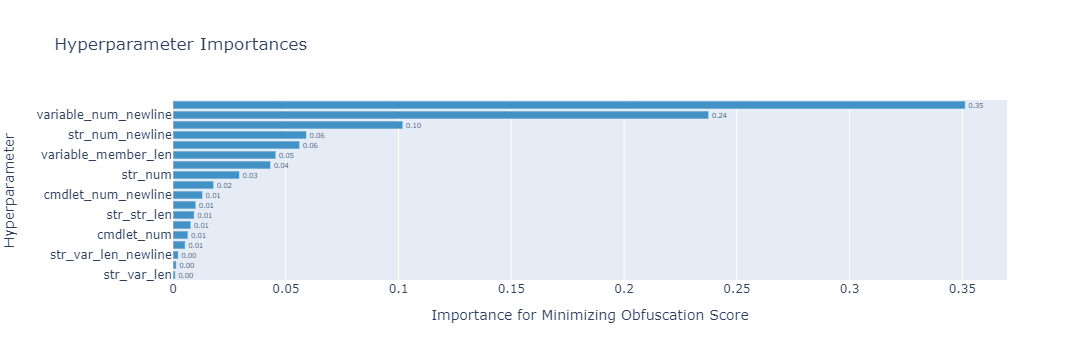

In [54]:
# For some additional insight, we can see the relative feature importances from the trial for each objective:
fig = optuna.visualization.plot_param_importances(study, target=lambda t: t.values[1], target_name="Minimizing Obfuscation Score")
fig.show()

This is something we'll explore in more detail in a future notebook.